In [1]:
from statistics import mean
import seaborn as sns
import networkx as nx
import pandas as pd
import time
import datetime
import freeman as fm
import operator
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import scipy

Carregamento das bases de dados

In [2]:
data = pd.read_csv('bill/hotStuff.csv')

In [3]:
data2 = pd.read_excel('bill/hot100.xlsx')

In [4]:
data2.columns

Index(['SongID', 'Performer', 'Song', 'spotify_genre', 'spotify_track_id',
       'spotify_track_preview_url', 'spotify_track_album',
       'spotify_track_explicit', 'spotify_track_duration_ms',
       'spotify_track_popularity', 'danceability', 'energy', 'key', 'loudness',
       'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'time_signature'],
      dtype='object')

In [5]:
def filtro(musica):
    new = musica.replace("#","")
    new = new.replace('"',"")
    new = new.replace("'","")
    new=new.replace("(","")
    new=new.replace(")","")
    new=new.replace("[","")
    new=new.replace("]","")
    new=new.replace("ç","c")
    new=new.replace("é","e")
    new=new.replace("ñ","n")
    new=new.replace("ò","o")
    new=new.replace("¿","?")
    new=new.replace("ó","o")
    new=new.replace("á","a")
    new=new.replace("ö","o")
    new=new.replace("Ó","O")
    new=new.replace("à","a")
    new=new.replace("�","?")
    
    
    return new

In [6]:
def sum100(number):
    return 100-number

In [7]:
def inv(number):
    return 1/number

In [8]:
def log(number):
    return np.log(number)

In [9]:
def loginv(number):
    return (1/(np.log(number)+1))

In [10]:
dic_func={sum100:"sum100",
          inv:"inv",
          log:"log",
          loginv:"loginv"}

In [11]:
def variaveis(func,name):
    dic={}
    for i in data.index:
        if data["SongID"][i] in dic:
            dic[data["SongID"][i]] += func(data["Week Position"][i])
        else:
            dic[data["SongID"][i]]= func(data["Week Position"][i])

    def go_to_apply (row):
        return dic[row['SongID']]

    data[name] = data.apply (lambda row: go_to_apply(row), axis=1)

In [12]:
for i in dic_func:
    variaveis(i,dic_func[i])

In [13]:
def diats(row):
    return pd.Timestamp(row["WeekID"])

In [14]:
data['timestamp']=data.apply (lambda row: diats(row), axis=1)

In [15]:
def musica_filtrada (row):
   return filtro(row['SongID'])

In [16]:
data2['SongFiltred']=data2.apply (lambda row: musica_filtrada(row), axis=1)

In [17]:
data.columns

Index(['url', 'WeekID', 'Week Position', 'Song', 'Performer', 'SongID',
       'Instance', 'Previous Week Position', 'Peak Position', 'Weeks on Chart',
       'sum100', 'inv', 'log', 'loginv', 'timestamp'],
      dtype='object')

In [18]:
data.drop_duplicates(subset=['SongID'],keep="first", inplace=True)

In [19]:
datamerge = pd.merge(data,data2,on='SongID')

In [20]:
data2000 = datamerge[datamerge["timestamp"]>=pd.Timestamp("1/1/2000")]

In [23]:
l_drop=['danceability',
       'energy', 'key', 'loudness', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness']
for i in l_drop:
    dl=data2000.dropna(axis=0, how="all", subset=[i], inplace=False)
    data2000=dl

In [24]:
datafixed = data2000.dropna(axis=0, how="all", subset=["spotify_genre"], inplace=False)
indexNames = datafixed[ datafixed['spotify_genre'] == "[]" ].index
data2000=datafixed.drop(indexNames , inplace=False)


In [25]:
indexNames

Int64Index([  730,   882,   962,   968,  1082,  1313,  1364,  1385,  1447,
             1449,
            ...
            27759, 27927, 28034, 28101, 28112, 28122, 28378, 28379, 28433,
            28467],
           dtype='int64', length=110)

In [26]:
datasorted = datafixed.sort_values(by=['timestamp'])

Função para checar se a string está na tabela ascii

In [27]:
datasorted["spotify_genre"]

21228    ['country', 'country road', 'country rock', 'o...
2700                         ['canadian pop', 'dance pop']
17527    ['bronx hip hop', 'east coast hip hop', 'gangs...
3025     ['candy pop', 'dance pop', 'europop', 'girl gr...
1479     ['dance pop', 'girl group', 'hip pop', 'pop', ...
                               ...                        
5241                           ['baton rouge rap', 'trap']
18586                ['dance pop', 'pop', 'post-teen pop']
11915                       ['chicago rap', 'melodic rap']
3163     ['melodic rap', 'philly rap', 'pop rap', 'rap'...
14548                ['dance pop', 'pop', 'post-teen pop']
Name: spotify_genre, Length: 7361, dtype: object

In [28]:
for i in data2000.index:
    print(data2000['spotify_genre'][i],type(data2000['spotify_genre'][i]))
#     if data2000['SongFiltred'][i] not in lista_musicas:
#         lista_musicas.append(data2000['SongFiltred'][i])

['dance pop', 'pop', 'post-teen pop'] <class 'str'>
['boy band', 'dance pop', 'pop', 'pop rock', 'post-teen pop'] <class 'str'>
['dance pop', 'pop', 'post-teen pop'] <class 'str'>
['canadian pop', 'pop', 'post-teen pop', 'viral pop'] <class 'str'>
['rap'] <class 'str'>
['pop', 'pop rap', 'rap'] <class 'str'>
['dance pop', 'pop'] <class 'str'>
['boy band', 'dance pop', 'pop', 'post-teen pop', 'talent show'] <class 'str'>
['australian pop', 'dance pop', 'pop', 'pop rap', 'post-teen pop', 'uk pop', 'viral pop'] <class 'str'>
['canadian hip hop', 'canadian pop', 'hip hop', 'pop rap', 'rap', 'toronto rap'] <class 'str'>
['pop', 'uk pop'] <class 'str'>
['conscious hip hop', 'hip hop', 'nc hip hop', 'pop rap', 'rap'] <class 'str'>
['dance pop', 'pop', 'pop rap'] <class 'str'>
['atl hip hop', 'dance pop', 'hip hop', 'pop', 'pop rap', 'rap', 'southern hip hop'] <class 'str'>
['pop', 'post-teen pop'] <class 'str'>
['detroit hip hop', 'g funk', 'hip hop', 'rap'] <class 'str'>
['conscious hip hop'

['latin', 'latin pop', 'puerto rican pop', 'tropical'] <class 'str'>
['dance pop', 'pop', 'post-teen pop'] <class 'str'>
['dance pop', 'latin', 'miami hip hop', 'pop', 'pop rap'] <class 'str'>
['dirty south rap', 'gangster rap', 'hip hop', 'pop rap', 'rap', 'southern hip hop'] <class 'str'>
['australian country', 'contemporary country', 'country', 'country road'] <class 'str'>
['belgian dance', 'belgian pop', 'eurodance', 'europop'] <class 'str'>
['contemporary country', 'country', 'country road', 'modern country rock', 'redneck'] <class 'str'>
['pop rap', 'rap', 'southern hip hop', 'trap'] <class 'str'>
['memphis hip hop'] <class 'str'>
['memphis hip hop'] <class 'str'>
['big room', 'dance pop', 'deep big room', 'dutch house', 'edm', 'electro house', 'pop', 'progressive electro house', 'progressive house', 'tropical house'] <class 'str'>
['contemporary country', 'country', 'country dawn', 'country road'] <class 'str'>
['contemporary country', 'country', 'country road', 'modern country

['contemporary country', 'country', 'country road', 'oklahoma country'] <class 'str'>
['contemporary country', 'country', 'country road', 'modern country rock', 'neo mellow', 'pop', 'pop rock', 'post-teen pop'] <class 'str'>
['contemporary country', 'country', 'country road', 'country rock'] <class 'str'>
['contemporary country', 'country', 'country road'] <class 'str'>
['contemporary country', 'country', 'country road', 'modern country rock', 'modern southern rock'] <class 'str'>
['arkansas country', 'contemporary country', 'country', 'country road', 'modern country rock'] <class 'str'>
['contemporary country', 'country', 'country dawn', 'country road', 'modern country rock'] <class 'str'>
['contemporary country', 'country', 'country road', 'modern country rock'] <class 'str'>
['bounce', 'crunk', 'dirty south rap', 'gangster rap', 'hip hop', 'new orleans rap', 'pop rap', 'rap', 'southern hip hop', 'trap'] <class 'str'>
['barbadian pop', 'dance pop', 'pop', 'post-teen pop', 'r&b', 'urb

['east coast hip hop', 'hardcore hip hop', 'hip hop', 'hip pop', 'old school hip hop', 'pop rap', 'queens hip hop', 'r&b', 'rap', 'southern hip hop', 'urban contemporary'] <class 'str'>
['atl hip hop'] <class 'str'>
['girl group', 'hip pop', 'neo soul', 'new jack swing', 'quiet storm', 'r&b', 'urban contemporary'] <class 'str'>
['east coast hip hop', 'gangster rap', 'hardcore hip hop', 'hip hop', 'rap', 'southern hip hop'] <class 'str'>
['crunk', 'dirty south rap', 'gangster rap', 'hip hop', 'hip pop', 'miami hip hop', 'pop rap', 'rap', 'southern hip hop', 'trap'] <class 'str'>
['contemporary country', 'country', 'country dawn', 'country road'] <class 'str'>
['album rock', 'classic rock', 'mellow gold', 'rock', 'soft rock', 'yacht rock'] <class 'str'>
['dirty south rap', 'gangster rap', 'hip hop', 'pop rap', 'rap', 'southern hip hop', 'trap'] <class 'str'>
['dance pop', 'electropop', 'girl group', 'indie poptimism', 'neo mellow', 'pop', 'post-teen pop'] <class 'str'>
['contemporary cou

['idol'] <class 'str'>
['canadian hip hop', 'canadian pop', 'hip hop', 'pop rap', 'rap', 'toronto rap'] <class 'str'>
['florida rap', 'hip hop', 'melodic rap', 'miami hip hop', 'pop rap', 'rap', 'southern hip hop', 'trap'] <class 'str'>
['dance pop', 'pop', 'post-teen pop'] <class 'str'>
['emo rap', 'trap'] <class 'str'>
['dance pop', 'pop', 'post-teen pop'] <class 'str'>
['alternative r&b', 'pop', 'pop rap'] <class 'str'>
['candy pop', 'dance pop', 'lilith', 'neo mellow', 'pop rock', 'post-teen pop'] <class 'str'>
['alternative rock', 'dance pop', 'permanent wave', 'pop rock', 'post-grunge'] <class 'str'>
['canadian latin', 'canadian pop', 'dance pop', 'pop', 'pop rap', 'pop rock'] <class 'str'>
['operatic pop'] <class 'str'>
['hip hop', 'new orleans rap', 'pop rap', 'rap', 'trap'] <class 'str'>
['dance pop', 'edm', 'pop', 'pop rap', 'post-teen pop'] <class 'str'>
['glee club', 'hollywood', 'post-teen pop'] <class 'str'>
['canadian indie', 'indie pop', 'indie poptimism', 'indietronica

['hip hop', 'philly rap', 'pop rap', 'rap', 'southern hip hop', 'trap'] <class 'str'>
['hip hop', 'pittsburgh rap', 'pop rap', 'rap', 'southern hip hop', 'trap'] <class 'str'>
['melodic rap', 'rap', 'trap'] <class 'str'>
['atl hip hop', 'pop rap', 'rap', 'trap'] <class 'str'>
['baton rouge rap', 'trap'] <class 'str'>
['dance pop', 'girl group', 'hip pop', 'pop', 'pop rap', 'r&b', 'urban contemporary'] <class 'str'>
['country', 'country road', 'country rock', 'redneck'] <class 'str'>
['alternative metal', 'alternative rock', 'pop rock', 'post-grunge'] <class 'str'>
['dance pop', 'new jack swing', 'quiet storm', 'r&b', 'urban contemporary'] <class 'str'>
['dance pop', 'hip hop', 'hip pop', 'neo soul', 'pop', 'r&b', 'urban contemporary'] <class 'str'>
['dance pop', 'deep pop r&b', 'hip pop', 'neo soul', 'new jack swing', 'pop rap', 'r&b', 'urban contemporary'] <class 'str'>
['hip pop', 'neo soul', 'pop', 'r&b', 'urban contemporary'] <class 'str'>
['alternative rock', 'grunge', 'permanent 

['reggae fusion', 'virgin islands reggae'] <class 'str'>
['canadian contemporary r&b', 'canadian pop', 'pop'] <class 'str'>
['canadian hip hop', 'canadian pop', 'hip hop', 'pop rap', 'rap', 'toronto rap'] <class 'str'>
['nc hip hop', 'trap'] <class 'str'>
['contemporary country', 'country', 'country road', 'modern country rock'] <class 'str'>
['dirty south rap', 'gangster rap', 'hip hop', 'memphis hip hop', 'pop rap', 'rap', 'southern hip hop', 'trap'] <class 'str'>
['atl hip hop', 'pop rap', 'rap', 'trap'] <class 'str'>
['dance pop', 'pop', 'post-teen pop'] <class 'str'>
['hip hop', 'indie pop rap', 'pop rap', 'rap'] <class 'str'>
['melodic rap', 'rap', 'trap'] <class 'str'>
['contemporary country', 'country', 'country road'] <class 'str'>
['alternative hip hop', 'art pop'] <class 'str'>
['contemporary country', 'country', 'country road'] <class 'str'>
['contemporary country', 'country road', 'modern country rock'] <class 'str'>
['hip hop', 'pop rap', 'rap'] <class 'str'>
['alternativ

['dance pop', 'deep pop r&b', 'hip pop', 'pop rap', 'post-teen pop', 'r&b', 'urban contemporary'] <class 'str'>
['contemporary country', 'country', 'country road', 'modern country rock'] <class 'str'>
['dance pop', 'deep pop r&b', 'hip hop', 'hip pop', 'neo soul', 'new jack swing', 'pop rap', 'quiet storm', 'r&b', 'urban contemporary'] <class 'str'>
['candy pop', 'country', 'country dawn'] <class 'str'>
['dance pop', 'east coast hip hop', 'hip hop', 'hip pop', 'pop rap', 'r&b', 'rap'] <class 'str'>
['arkansas country', 'contemporary country', 'country', 'country road', 'country rock'] <class 'str'>
['crunk', 'dirty south rap', 'gangster rap', 'hip hop', 'houston rap', 'pop rap', 'rap', 'southern hip hop', 'trap'] <class 'str'>
['australian country', 'contemporary country', 'country', 'country road'] <class 'str'>
['contemporary country', 'country', 'country road', 'country rock', 'modern country rock'] <class 'str'>
['atl hip hop', 'dirty south rap', 'hip hop', 'pop rap', 'rap', 'south

['british soul', 'pop', 'uk pop'] <class 'str'>
['dance pop', 'pop', 'post-teen pop'] <class 'str'>
['conscious hip hop', 'dmv rap', 'hip hop', 'pop rap', 'rap'] <class 'str'>
['electropop', 'pop', 'tropical house'] <class 'str'>
['conscious hip hop', 'hip hop', 'nc hip hop', 'pop rap', 'rap'] <class 'str'>
['alternative r&b', 'pop'] <class 'str'>
['atl hip hop', 'hip hop', 'pop rap', 'rap', 'southern hip hop', 'trap'] <class 'str'>
['melodic rap', 'rap', 'trap'] <class 'str'>
['canadian hip hop', 'melodic rap', 'pop rap', 'rap', 'toronto rap', 'trap'] <class 'str'>
['la indie', 'pop', 'pop rap'] <class 'str'>
['east coast hip hop', 'gangster rap', 'hip hop', 'pop rap', 'queens hip hop', 'rap'] <class 'str'>
['canadian ccm', 'christian alternative rock', 'christian music', 'christian punk', 'christian rock', 'indiecoustica', 'neo mellow', 'pop punk', 'pop rock'] <class 'str'>
['album rock', 'classic rock', 'folk rock', 'heartland rock', 'mellow gold', 'pop rock', 'rock', 'singer-songwr

['gangster rap', 'hip hop', 'hyphy', 'rap', 'west coast rap', 'west coast trap'] <class 'str'>
['dance pop', 'europop', 'hip pop', 'pop', 'pop rock', 'post-teen pop'] <class 'str'>
['canadian hip hop', 'melodic rap', 'pop rap', 'rap', 'toronto rap', 'trap'] <class 'str'>
['contemporary country', 'country', 'country road'] <class 'str'>
['dance pop', 'pop', 'pop rap'] <class 'str'>
['idol', 'neo mellow', 'pop rock', 'talent show'] <class 'str'>
['contemporary country', 'country', 'country road', 'modern country rock'] <class 'str'>
['contemporary country', 'country', 'country road', 'country rock', 'redneck'] <class 'str'>
['contemporary country', 'country', 'country road'] <class 'str'>
['dance pop', 'pop', 'post-teen pop', 'r&b'] <class 'str'>
['indie pop', 'indie poptimism', 'la indie', 'modern rock', 'pop rock'] <class 'str'>
['dance pop', 'pop', 'post-teen pop', 'viral pop'] <class 'str'>
['detroit hip hop', 'g funk', 'hip hop', 'rap'] <class 'str'>
['acoustic pop', 'ectofolk', 'in

['dance pop', 'latin', 'latin arena pop', 'latin pop', 'mexican pop'] <class 'str'>
['country road', 'texas country'] <class 'str'>
['acoustic pop', 'chamber pop', 'indie pop', 'lilith', 'piano rock', 'pop rock'] <class 'str'>
['dance pop', 'pop', 'pop rap', 'post-teen pop'] <class 'str'>
['arkansas country', 'contemporary country', 'country', 'country road', 'modern country rock'] <class 'str'>
['contemporary country', 'country', 'country road', 'modern country rock'] <class 'str'>
['dance pop', 'pop', 'pop rap', 'r&b'] <class 'str'>
['barbadian pop', 'dance pop', 'pop', 'post-teen pop', 'r&b', 'urban contemporary'] <class 'str'>
['australian country', 'contemporary country', 'country', 'country road'] <class 'str'>
['neo mellow'] <class 'str'>
['contemporary country', 'country', 'country road'] <class 'str'>
['dance pop', 'edm', 'pop'] <class 'str'>
['contemporary country', 'country', 'country road', 'modern country rock', 'oklahoma country', 'redneck'] <class 'str'>
['country road',

['dirty south rap', 'gangster rap', 'hip hop', 'pop rap', 'rap', 'southern hip hop'] <class 'str'>
['neo mellow', 'pop', 'pop rock', 'singer-songwriter'] <class 'str'>
['contemporary country', 'country', 'country road', 'modern country rock'] <class 'str'>
['rebel blues'] <class 'str'>
['dance pop', 'electropowerpop', 'pop', 'pop rap', 'post-teen pop'] <class 'str'>
['acoustic pop', 'neo mellow', 'pop rock', 'post-grunge'] <class 'str'>
['atl hip hop', 'dance pop', 'pop', 'pop rap', 'r&b', 'urban contemporary'] <class 'str'>
['alternative metal', 'christian rock', 'nu metal', 'post-grunge', 'rap rock'] <class 'str'>
['dance pop', 'pop', 'r&b', 'urban contemporary'] <class 'str'>
['atl hip hop', 'dirty south rap', 'pop rap', 'rap', 'southern hip hop', 'trap'] <class 'str'>
['bow pop', 'emo', 'pop punk', 'pop rock', 'post-grunge', 'socal pop punk'] <class 'str'>
['dance pop', 'pop', 'pop rap', 'r&b', 'trap', 'urban contemporary'] <class 'str'>
['pop', 'pop rock'] <class 'str'>
['dirty so

['contemporary country', 'country', 'country dawn', 'country road'] <class 'str'>
['atl hip hop', 'pop rap', 'rap', 'trap'] <class 'str'>
['atl hip hop', 'crunk', 'dirty south rap', 'gangster rap', 'pop rap', 'rap', 'southern hip hop', 'trap'] <class 'str'>
['pop rap'] <class 'str'>
['contemporary country', 'country', 'country road', 'oklahoma country'] <class 'str'>
['deep pop r&b', 'slow game'] <class 'str'>
['hip hop', 'rap'] <class 'str'>
['dance pop', 'edm', 'miami hip hop', 'pop', 'pop rap'] <class 'str'>
['blues rock', 'modern blues'] <class 'str'>
['cali rap', 'hip hop', 'pop rap', 'rap', 'southern hip hop', 'trap'] <class 'str'>
['electropop', 'pop', 'tropical house'] <class 'str'>
['canadian ccm', 'christian alternative rock', 'christian music', 'christian punk', 'christian rock', 'indiecoustica', 'neo mellow', 'pop punk', 'pop rock'] <class 'str'>
['contemporary country', 'country', 'country road', 'modern country rock'] <class 'str'>
['contemporary country', 'country', 'cou

['australian dance', 'australian house', 'bass house'] <class 'str'>
['atl hip hop', 'gangster rap', 'hip hop', 'pop rap', 'rap', 'southern hip hop', 'trap'] <class 'str'>
['boy band', 'dance pop', 'pop', 'pop rock', 'post-teen pop', 'viral pop'] <class 'str'>
['contemporary country', 'country', 'country dawn', 'country pop', 'country road'] <class 'str'>
['post-teen pop'] <class 'str'>
['australian dance', 'australian pop', 'electropop'] <class 'str'>
['dance pop', 'hip hop', 'hip pop', 'pop', 'pop rap', 'r&b', 'urban contemporary'] <class 'str'>
['dance pop', 'hip hop', 'miami hip hop', 'pop', 'pop rap', 'rap', 'southern hip hop', 'trap'] <class 'str'>
['alternative hip hop', 'conscious hip hop', 'east coast hip hop', 'gangster rap', 'hardcore hip hop', 'hip hop', 'jazz rap', 'queens hip hop', 'rap'] <class 'str'>
['bronx hip hop', 'east coast hip hop', 'gangster rap', 'hardcore hip hop', 'hip hop', 'hip pop', 'pop rap', 'rap', 'trap'] <class 'str'>
['contemporary country', 'country'

In [29]:
def is_ascii(s):
    return all(ord(c) < 128 for c in s)

Filtro aplicado no songid

Dicionário dos SongIDs e as respectivas semanas na Bilboard

Filtro aplicado no nome das músicas

In [30]:
import re

dic_bugs={
    "Lil Nas &":"Lil Nas X",
    "& Ambassadors":"X Ambassadors",
    "Mia &":"Mia X",
    "for KING & COUNTRY":"for KING and COUNTRY",
    "Brooks & Dunn":"Brooks and Dunn"   
}

feat="Featuring"
def parse(nomes):
    
    new_nomes=nomes.replace("(","")
    new_nomes=new_nomes.replace(")","")
    new_nomes=new_nomes.replace("[","")
    new_nomes=new_nomes.replace("]","")
    new_nomes=new_nomes.replace('"',"")
    new_nomes=new_nomes.replace(", "," & ")
    new_nomes=new_nomes.replace("Featuring","&")
    new_nomes=new_nomes.replace("Feat.","&")
    new_nomes=new_nomes.replace(" Or "," & ")
    new_nomes=new_nomes.replace(" X "," & ")
    new_nomes=new_nomes.replace(" x "," & ")
    for i in dic_bugs:
        if i in new_nomes:
            new_nomes=new_nomes.replace(i,dic_bugs[i])
    return re.split(r'\s[,&+]\s', new_nomes)

In [31]:
# def createmultifeat(lista):
#     final=[]
#     for i in range(len(lista)):
#         for j in range(i+1,len(lista)):
#             final.append([lista[i],lista[j]])
#     return final
# print (createmultifeat(['NAV', 'Meek Mill',"oi"]))

In [32]:
# def createsinglefeat(lista):
#     final=[]
#     for i in range(1,len(lista)):
#         final.append([lista[0],lista[i]])
#     return final
# print (createmultifeat(['NAV', 'Meek Mill',"oi"]))

In [33]:
def insertfeat(lista_mc,lista,songid):
    for i in lista:
        if [songid,i] not in lista_mc:
            lista_mc.append([songid,i])

In [34]:
data2000=data2000.reset_index(drop=True)

In [35]:
data2000.loc[:20,['SongID','sum100', 'inv', 'log', 'loginv']]

,SongID,sum100,inv,log,loginv
0,7 RingsAriana Grande,2830,11.156417,64.119406,15.727200
1,SuckerJonas Brothers,3356,5.679178,83.756044,12.804762
2,"Break Up With Your Girlfriend, I'm BoredAriana...",1603,1.612863,56.310941,5.488270
3,SenoritaShawn Mendes & Camila Cabello,2477,9.219643,32.182906,12.735303
4,Sicko ModeTravis Scott,4357,9.087572,117.931851,18.154583
5,Please MeCardi B & Bruno Mars,1504,2.023465,55.148707,5.765923
6,ApplauseLady Gaga,1962,2.316621,56.795969,6.842224
7,Story Of My LifeOne Direction,2586,2.290108,88.851962,8.654289
8,"Bang BangJessie J, Ariana Grande & Nicki Minaj",2615,3.956246,74.146948,9.776528
9,Summer SixteenDrake,822,0.508707,49.939325,3.139500


In [36]:
lista_musicas=[]
for i in data2000.index:
    print(i)
    if data2000['SongFiltred'][i] not in lista_musicas:
        lista_musicas.append(data2000['SongFiltred'][i])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

2378
2379
2380
2381
2382
2383
2384
2385
2386
2387
2388
2389
2390
2391
2392
2393
2394
2395
2396
2397
2398
2399
2400
2401
2402
2403
2404
2405
2406
2407
2408
2409
2410
2411
2412
2413
2414
2415
2416
2417
2418
2419
2420
2421
2422
2423
2424
2425
2426
2427
2428
2429
2430
2431
2432
2433
2434
2435
2436
2437
2438
2439
2440
2441
2442
2443
2444
2445
2446
2447
2448
2449
2450
2451
2452
2453
2454
2455
2456
2457
2458
2459
2460
2461
2462
2463
2464
2465
2466
2467
2468
2469
2470
2471
2472
2473
2474
2475
2476
2477
2478
2479
2480
2481
2482
2483
2484
2485
2486
2487
2488
2489
2490
2491
2492
2493
2494
2495
2496
2497
2498
2499
2500
2501
2502
2503
2504
2505
2506
2507
2508
2509
2510
2511
2512
2513
2514
2515
2516
2517
2518
2519
2520
2521
2522
2523
2524
2525
2526
2527
2528
2529
2530
2531
2532
2533
2534
2535
2536
2537
2538
2539
2540
2541
2542
2543
2544
2545
2546
2547
2548
2549
2550
2551
2552
2553
2554
2555
2556
2557
2558
2559
2560
2561
2562
2563
2564
2565
2566
2567
2568
2569
2570
2571
2572
2573
2574
2575
2576
2577


4080
4081
4082
4083
4084
4085
4086
4087
4088
4089
4090
4091
4092
4093
4094
4095
4096
4097
4098
4099
4100
4101
4102
4103
4104
4105
4106
4107
4108
4109
4110
4111
4112
4113
4114
4115
4116
4117
4118
4119
4120
4121
4122
4123
4124
4125
4126
4127
4128
4129
4130
4131
4132
4133
4134
4135
4136
4137
4138
4139
4140
4141
4142
4143
4144
4145
4146
4147
4148
4149
4150
4151
4152
4153
4154
4155
4156
4157
4158
4159
4160
4161
4162
4163
4164
4165
4166
4167
4168
4169
4170
4171
4172
4173
4174
4175
4176
4177
4178
4179
4180
4181
4182
4183
4184
4185
4186
4187
4188
4189
4190
4191
4192
4193
4194
4195
4196
4197
4198
4199
4200
4201
4202
4203
4204
4205
4206
4207
4208
4209
4210
4211
4212
4213
4214
4215
4216
4217
4218
4219
4220
4221
4222
4223
4224
4225
4226
4227
4228
4229
4230
4231
4232
4233
4234
4235
4236
4237
4238
4239
4240
4241
4242
4243
4244
4245
4246
4247
4248
4249
4250
4251
4252
4253
4254
4255
4256
4257
4258
4259
4260
4261
4262
4263
4264
4265
4266
4267
4268
4269
4270
4271
4272
4273
4274
4275
4276
4277
4278
4279


6013
6014
6015
6016
6017
6018
6019
6020
6021
6022
6023
6024
6025
6026
6027
6028
6029
6030
6031
6032
6033
6034
6035
6036
6037
6038
6039
6040
6041
6042
6043
6044
6045
6046
6047
6048
6049
6050
6051
6052
6053
6054
6055
6056
6057
6058
6059
6060
6061
6062
6063
6064
6065
6066
6067
6068
6069
6070
6071
6072
6073
6074
6075
6076
6077
6078
6079
6080
6081
6082
6083
6084
6085
6086
6087
6088
6089
6090
6091
6092
6093
6094
6095
6096
6097
6098
6099
6100
6101
6102
6103
6104
6105
6106
6107
6108
6109
6110
6111
6112
6113
6114
6115
6116
6117
6118
6119
6120
6121
6122
6123
6124
6125
6126
6127
6128
6129
6130
6131
6132
6133
6134
6135
6136
6137
6138
6139
6140
6141
6142
6143
6144
6145
6146
6147
6148
6149
6150
6151
6152
6153
6154
6155
6156
6157
6158
6159
6160
6161
6162
6163
6164
6165
6166
6167
6168
6169
6170
6171
6172
6173
6174
6175
6176
6177
6178
6179
6180
6181
6182
6183
6184
6185
6186
6187
6188
6189
6190
6191
6192
6193
6194
6195
6196
6197
6198
6199
6200
6201
6202
6203
6204
6205
6206
6207
6208
6209
6210
6211
6212


In [37]:
print("Break Up With Your Girlfriend, I'm BoredAriana Grande" in lista_musicas)

False


In [38]:
data2000.index

RangeIndex(start=0, stop=7251, step=1)

In [39]:
lista_cantores=[]
lista_participacao=[]
dic_SongID_Performers={}
s=0
for i in data2000.index:
    lista_singers = parse(data2000["Performer_x"][i])
    print(lista_singers)
    print(i)
    for j in lista_singers:
        if j not in lista_cantores:
            lista_cantores.append(j)
            
    if len(lista_singers)>1:
        insertfeat(lista_participacao,lista_singers,data2000["SongFiltred"][i])

['Ariana Grande']
0
['Jonas Brothers']
1
['Ariana Grande']
2
['Shawn Mendes', 'Camila Cabello']
3
['Travis Scott']
4
['Cardi B', 'Bruno Mars']
5
['Lady Gaga']
6
['One Direction']
7
['Jessie J', 'Ariana Grande', 'Nicki Minaj']
8
['Drake']
9
['Ed Sheeran']
10
['J. Cole']
11
['Akon']
12
['B.o.B', 'Lil Wayne']
13
['Taylor Swift']
14
['Eminem']
15
['J. Cole']
16
['The Chainsmokers']
17
['Drake']
18
['The Weeknd', 'Kendrick Lamar']
19
['Post Malone']
20
['Billie Eilish']
21
['Billie Eilish']
22
['Post Malone']
23
['Coldplay']
24
['Miley Cyrus']
25
['Taylor Swift']
26
['Glee Cast']
27
['Adele']
28
['Maroon 5']
29
['Kelly Clarkson']
30
['Drake']
31
['Travis Scott']
32
['BTS', 'Halsey']
33
['Ariana Grande', 'Social House']
34
['Post Malone', 'Ozzy Osbourne', 'Travis Scott']
35
['P!nk']
36
['Lady Gaga']
37
['Lil Wayne', 'Cory Gunz']
38
['Drake', 'Rihanna']
39
['Nicki Minaj']
40
['The Chainsmokers', 'Halsey']
41
['Drake', 'Quavo', 'Travis Scott']
42
['Justin Timberlake', 'Chris Stapleton']
43
['T

['The Pussycat Dolls', 'Busta Rhymes']
563
['Chamillionaire', 'Krayzie Bone']
564
['Snoop Dogg', 'Pharrell', 'Uncle Charlie Wilson']
565
['Rich The Kid']
566
['Tyga', 'Offset']
567
['Gwen Stefani']
568
['Rihanna']
569
['Madonna']
570
['Evanescence', 'Paul McCoy']
571
['Monica']
572
['Dirty Vegas']
573
['DaBaby']
574
['DaBaby']
575
['Janet']
576
['Mary J. Blige', 'Ja Rule']
577
['Calvin Harris']
578
['Kelly Clarkson']
579
['Iyaz']
580
['Field Mob', 'Ciara']
581
['Timbaland', 'Justin Timberlake']
582
['T-Pain', 'Wiz Khalifa', 'Lily Allen']
583
['Nicki Minaj', 'Drake', 'Lil Wayne', 'Chris Brown']
584
['Ashanti']
585
['Young Dro', 'T.I.']
586
['Olivia']
587
['Sean Kingston']
588
['Chingy']
589
['Mystikal']
590
['Justin Bieber', 'Usher']
591
['Chris Brown']
592
['Britney Spears']
593
['Maroon 5']
594
['Kanye West', 'Jay-Z', 'Big Sean']
595
["Destiny's Child"]
596
['Eminem']
597
['Rihanna']
598
['Green Day']
599
['Ariana Grande']
600
['Far*East Movement', 'Ryan Tedder']
601
['matchbox twenty

970
['Drake']
971
['A$AP Rocky', 'Skepta']
972
['Khalid']
973
['Khalid']
974
['Taylor Swift']
975
['Gym Class Heroes']
976
['Glee Cast']
977
['Gwen Stefani']
978
['The Weeknd', 'Future']
979
['Burl Ives']
980
['Burl Ives']
981
['Katy Perry', 'Nicki Minaj']
982
['Post Malone']
983
['Playboi Carti', 'Lil Uzi Vert']
984
['6ix9ine', 'DJ SPINKING']
985
['Trippie Redd']
986
['Lil Baby']
987
['Future']
988
['Billie Eilish']
989
['Billie Eilish']
990
['Linkin Park']
991
['Kanye West']
992
['Glee Cast']
993
['Justin Timberlake']
994
['Justin Bieber']
995
['5 Seconds Of Summer']
996
['Eminem']
997
['The Weeknd', 'Lana Del Rey']
998
['The Weeknd']
999
['Camila Cabello']
1000
['Post Malone']
1001
['Travis Scott']
1002
['Lil Wayne']
1003
['Miley Cyrus']
1004
['Missy Elliott']
1005
['Usher']
1006
['Wiz Khalifa']
1007
['Bow Wow', 'Lil Wayne']
1008
['T-Pain', 'Lil Wayne']
1009
['Migos', 'Gucci Mane']
1010
['Future', 'The Weeknd']
1011
['Migos', '21 Savage']
1012
['Carrie Underwood']
1013
['Travis Scot

['MAGIC!']
1470
['Wiz Khalifa', 'Charlie Puth']
1471
['LMFAO']
1472
['OMI']
1473
['Ja Rule', 'Ashanti']
1474
['Beyonce', 'Slim Thug']
1475
['Meghan Trainor']
1476
['Rae Sremmurd', 'Gucci Mane']
1477
['The Black Eyed Peas']
1478
['Migos', 'Lil Uzi Vert']
1479
['Ciara', 'Missy Elliott']
1480
['Hozier']
1481
['Jennifer Lopez', 'Ja Rule']
1482
['Beyonce', 'Jay Z']
1483
['Sean Paul']
1484
['Leona Lewis']
1485
['Desiigner']
1486
['Janet']
1487
['Shaggy', 'Rayvon']
1488
['Jamie Foxx', 'T-Pain']
1489
['Avril Lavigne']
1490
['Rihanna']
1491
['Ludacris', 'Shawnna']
1492
['T-Pain', 'Yung Joc']
1493
['Gnarls Barkley']
1494
['Lukas Graham']
1495
['Kid Cudi']
1496
['Jason Derulo', '2 Chainz']
1497
['Mary J. Blige']
1498
['Beyonce']
1499
['Twista', 'Kanye West', 'Jamie Foxx']
1500
['Justin Timberlake']
1501
['50 Cent', 'Nate Dogg']
1502
["Lil' Flip", 'Lea']
1503
['Akon', 'Eminem']
1504
['Nicki Minaj']
1505
['Gym Class Heroes', 'Adam Levine']
1506
['Nico', 'Vinz']
1507
['Faith Hill']
1508
['Nelly Furt

['Shania Twain']
2060
['Fantasia']
2061
['French Montana']
2062
['Driicky Graham']
2063
['Death Cab For Cutie']
2064
['Kenny Chesney']
2065
['Wale', 'Rick Ross', 'Meek Mill', 'T-Pain']
2066
['Keith Anderson']
2067
['KT Tunstall']
2068
['The Raconteurs']
2069
['Roscoe Dash', "Soulja Boy Tell'em"]
2070
['Keith Urban']
2071
['Mike Jones', 'Slim Thug', 'Paul Wall']
2072
['Bilal']
2073
['Ying Yang Twins']
2074
['Charlie Wilson']
2075
['Alan Jackson']
2076
['Ace Hood', 'Chris Brown']
2077
['Jimmy Eat World']
2078
['Lasgo']
2079
['Audioslave']
2080
['Sharissa']
2081
['Fantasia']
2082
['Keyshia Cole', '2Pac']
2083
['Pia Mia X Chris Brown', 'Tyga']
2084
['Ginuwine', 'R.L.', 'Tyrese', 'Case']
2085
['Chris Young', 'Vince Gill']
2086
['Chris Cagle']
2087
['Luke Bryan']
2088
['Bryson Tiller']
2089
['Jerrod Niemann']
2090
['Barenaked Ladies']
2091
['Nas']
2092
['Jason Michael Carroll']
2093
['Juvenile']
2094
['Cupid']
2095
['My Chemical Romance']
2096
['SoMo']
2097
['Beyonce']
2098
['Boyz N Da Hood'

['Billie Eilish']
2558
['DJ Khaled', 'SZA']
2559
['DJ Khaled', 'SZA']
2560
['DaBaby', 'Nicki Minaj']
2561
['Enrique Iglesias']
2562
['50 Cent']
2563
['Nickelback']
2564
['Charice']
2565
['Lil Wayne', 'Nicki Minaj']
2566
['Maroon 5']
2567
['Jose Feliciano']
2568
['Jose Feliciano']
2569
['Lana Del Rey']
2570
['Zayn', 'Sia']
2571
['YoungBoy Never Broke Again']
2572
['Tim McGraw']
2573
['Waka Flocka Flame', 'Roscoe Dash', 'Wale']
2574
['Glee Cast']
2575
['Adam Levine', 'Javier Colon']
2576
['2 Chainz', 'Drake']
2577
['Lady Antebellum']
2578
['Romeo Santos', 'Drake']
2579
['Maroon 5']
2580
['Ellie Goulding']
2581
['Drake', 'Jorja Smith', 'Black Coffee']
2582
['Queen Naija']
2583
['John', 'Yoko/The Plastic Ono Band With The Harlem Community Choir']
2584
['Halsey']
2585
['Kanye West', 'Sunday Service Choir']
2586
['Jennifer Lopez']
2587
['Nas']
2588
['The Game']
2589
['Michael Buble']
2590
['Boys Like Girls']
2591
['Ludacris', 'Nicki Minaj']
2592
['Sean Kingston', 'Nicki Minaj']
2593
['Ed She

2963
['Mariah Carey']
2964
['Mariah Carey']
2965
['6LACK']
2966
['Rich The Kid']
2967
['Kendrick Lamar']
2968
['Devin Dawson']
2969
['Chris Stapleton']
2970
['Ronnie Dunn']
2971
['Gorillaz', 'Shaun Ryder']
2972
['Dr. Dre', 'Snoop Dogg']
2973
['Meghan Trainor']
2974
['The Ting Tings']
2975
['Jessie J', '2 Chainz']
2976
['Colbie Caillat']
2977
['Fabolous', 'Chris Brown']
2978
['Adele']
2979
['Dierks Bentley']
2980
['Tyga', 'Nicki Minaj']
2981
['ScHoolboy Q', 'Kendrick Lamar']
2982
['My Darkest Days', 'Zakk Wylde']
2983
['Romeo Santos']
2984
['Mat Kearney']
2985
['LeToya', 'Ludacris']
2986
['Cage The Elephant']
2987
['Musiq Soulchild']
2988
['Theory Of A Deadman']
2989
['Weezer']
2990
['YoungBloodZ']
2991
['Ian Van Dahl', 'Marsha']
2992
['Marshmello']
2993
['Jesse McCartney']
2994
['Phoenix']
2995
['Mannie Fresh']
2996
['Kendrick Lamar']
2997
['Wale', 'Jeremih']
2998
['Maren Morris']
2999
['Rick Ross', 'T-Pain']
3000
['Roddy Ricch']
3001
['Glee Cast']
3002
['Kenny Chesney']
3003
['The Ata

3328
['Pusha T']
3329
['Juice WRLD']
3330
['Juice WRLD']
3331
['Eminem', 'Jessie Reyez']
3332
['Future']
3333
['Offset', 'J. Cole']
3334
['Juice WRLD']
3335
['Nipsey Hussle', 'Belly', 'DOM KENNEDY']
3336
['Nelly Furtado']
3337
['Jennifer Lopez', 'Ja Rule']
3338
['Linkin Park']
3339
['John Michael Montgomery']
3340
['Kenny Chesney']
3341
['Ludacris']
3342
['Bow Wow', "Soulja Boy Tell'em"]
3343
['Pitbull']
3344
['Mariah Carey']
3345
['Daughtry']
3346
['Glee Cast']
3347
['T.I.', 'Big K.R.I.T.']
3348
['Avicii']
3349
['Glee Cast']
3350
['Tyga', 'Cedric Gervais', 'Wiz Khalifa', 'Mally Mall']
3351
['Tove Lo']
3352
['Kid Rock']
3353
['Nicky Jam', 'Enrique Iglesias']
3354
['Drake']
3355
['YoungBoy Never Broke Again']
3356
['Mobb Deep', '112']
3357
['Dixie Chicks']
3358
['Justin Timberlake']
3359
['Jennifer Lopez', 'Styles', 'Jadakiss']
3360
['Ja Rule', 'Ashanti']
3361
['50 Cent']
3362
['Fabolous', 'Tamia', 'Ashanti']
3363
['Mary J. Blige', 'Eve']
3364
["Lil' Flip"]
3365
['The Black Eyed Peas']


3713
['Good Charlotte']
3714
['Incubus']
3715
['Jo Dee Messina']
3716
['Switchfoot']
3717
['Clay Walker']
3718
['Houston', 'Chingy', 'Nate Dogg', 'I-20']
3719
['Gary Allan']
3720
['Papa Roach']
3721
['LeAnn Rimes']
3722
['Alan Jackson']
3723
['Big', 'Rich']
3724
['Ciara', 'Ludacris']
3725
['The Fratellis']
3726
['Kanye West', 'Dwele']
3727
['Jamie Foxx', 'T.I.']
3728
['Kristinia DeBarge']
3729
['The Black Eyed Peas']
3730
['Taylor Swift']
3731
['Nelly', 'Keri Hilson']
3732
['Jana Kramer']
3733
['Billy Currington']
3734
['Future']
3735
['Avril Lavigne']
3736
['Ella Henderson']
3737
['Sam Smith']
3738
['Steven Tyler']
3739
['Ruth B']
3740
['Drake']
3741
['Meek Mill']
3742
['Rich The Kid', 'Kendrick Lamar']
3743
['Lil Wayne']
3744
['Marshmello', 'CHVRCHES']
3745
['Marshmello', 'CHVRCHES']
3746
['Dreamville', 'JID', 'Bas', 'J. Cole', 'EARTHGANG', 'Young Nudy']
3747
['Trevor Daniel']
3748
['Britney Spears']
3749
['Alan Jackson']
3750
['Ruff Endz']
3751
['Toni Braxton']
3752
['3 Doors Down']

['OK Go']
4311
['Nick Lachey']
4312
['Beyonce']
4313
['Timbaland', 'Nelly Furtado', 'Justin Timberlake']
4314
['Young Buck']
4315
['Duffy']
4316
['Craig Morgan']
4317
['Mike Jones']
4318
['Paula Abdul']
4319
['Hannah Montana']
4320
['Miranda Cosgrove']
4321
['Glee Cast']
4322
['Ace Hood']
4323
['Rascal Flatts', 'Natasha Bedingfield']
4324
['Wale', 'Miguel']
4325
['Glee Cast']
4326
['Andy Grammer']
4327
['The Script', 'will.i.am']
4328
['Wiz Khalifa', 'Akon']
4329
['The Band Perry']
4330
['Enrique Iglesias', 'Romeo Santos']
4331
['Miley Cyrus']
4332
['Rixton']
4333
['Brantley Gilbert']
4334
['Jennifer Lopez']
4335
['Shaggy', 'Mohombi', 'Faydee', 'Costi']
4336
['Charlie Puth', 'Meghan Trainor']
4337
['Nick Jonas']
4338
['Lil Wayne', 'Charlie Puth']
4339
['Future']
4340
['One Direction']
4341
['Yo Gotti', 'Nicki Minaj']
4342
['Rascal Flatts']
4343
['Migos']
4344
['YFN Lucci', 'Migos', 'Trouble']
4345
['Julia Michaels']
4346
['Major Lazer', 'Travis Scott', 'Camila Cabello', 'Quavo']
4347
[

['LL Cool J']
4679
['Busta Rhymes', 'Spliff Star']
4680
['Nick Cannon', 'B2K']
4681
['Ginuwine']
4682
['Seal']
4683
['Alicia Keys']
4684
['Xzibit', 'Keri Hilson']
4685
['Toby Keith']
4686
['Mario']
4687
['Bow Wow', 'Omarion']
4688
['Kenny Chesney']
4689
['Garth Brooks']
4690
['System Of A Down']
4691
['Toby Keith']
4692
['The Fray']
4693
['Rascal Flatts']
4694
['The Red Jumpsuit Apparatus']
4695
['Ciara', 'Chamillionaire']
4696
['Mat Kearney']
4697
['My Chemical Romance']
4698
['The Pussycat Dolls']
4699
['Jack Johnson']
4700
['will.i.am']
4701
['matchbox twenty']
4702
['DJ Khaled', 'T-Pain', 'Trick Daddy', 'Rick Ross', 'Plies']
4703
['Alicia Keys']
4704
['Landon Pigg']
4705
['James Otto']
4706
['Jason Mraz']
4707
['Lloyd', 'Lil Wayne']
4708
['Bucky Covington']
4709
['Gorilla Zoe']
4710
['Lee Ann Womack']
4711
['Beyonce']
4712
['M.I.A.', 'A R Rahman']
4713
['Selena Gomez', 'The Scene']
4714
['Lady Antebellum']
4715
['Gucci Mane']
4716
['Big Time Rush']
4717
['Glee Cast']
4718
['Waka Fl

['Frank Ocean']
5004
['Rae Sremmurd']
5005
['The Carters']
5006
['XXXTENTACION']
5007
['Lil Tecca']
5008
['Harry Styles']
5009
['Trisha Yearwood']
5010
['Cher']
5011
['Britney Spears']
5012
['Godsmack']
5013
['Ying Yang Twins', 'Wyclef']
5014
['Three 6 Mafia', 'Chamillionaire']
5015
['R.E.M.']
5016
['Mike Jones', 'Trey Songz', 'Twista']
5017
['Three 6 Mafia', 'Kalenna']
5018
['Glee Cast']
5019
['Britney Spears']
5020
['Jeezy', 'Jay Z']
5021
['Drake', 'PARTYNEXTDOOR']
5022
['Blink-182']
5023
['Zara Larsson']
5024
['Kehlani']
5025
['BTS']
5026
['Zac Efron', 'Zendaya']
5027
['Migos']
5028
['Meek Mill']
5029
['Drake']
5030
['XXXTENTACION', 'PnB Rock', 'Trippie Redd']
5031
['Garth Brooks']
5032
['The Shins']
5033
['Jennifer Lopez']
5034
['Snow Patrol', 'Martha Wainwright']
5035
['Glee Cast']
5036
['Nicole Scherzinger']
5037
['Juliet Simms']
5038
['Melanie Martinez']
5039
['Drake', 'Future']
5040
['Britney Spears', 'Tinashe']
5041
['Big Sean']
5042
['A Boogie Wit da Hoodie', 'PnB Rock', 'You

5372
['Wisin', 'Yandel']
5373
['Pitbull']
5374
['Breaking Benjamin']
5375
['Hilary Duff']
5376
['Alicia Keys']
5377
['Pleasure P']
5378
['Bobby V', 'Yung Joc']
5379
['Toby Keith']
5380
['V V Brown']
5381
['Ne-Yo']
5382
['Glee Cast']
5383
['Jill Scott', 'Anthony Hamilton']
5384
['Don Omar']
5385
['Waka Flocka Flame', 'Drake']
5386
['Foster The People']
5387
['Trey Songz']
5388
['Kelly Clarkson', 'Vince Gill']
5389
['Amanda Brown']
5390
['Ludacris', 'Kelly Rowland']
5391
['Charlie Worsham']
5392
['Miranda Lambert']
5393
['TeeFLii', '2 Chainz']
5394
['Drake']
5395
['Big Sean', 'Kanye West', 'John Legend']
5396
['PSY', 'CL']
5397
['Rick Ross', 'Chris Brown']
5398
['Curren$Y', 'August Alsina', 'Lil Wayne']
5399
['Meek Mill']
5400
['Logic']
5401
['Lil Baby']
5402
['Luke Combs', 'Brooks and Dunn']
5403
['Internet Money', 'Lil Tecca', 'A Boogie Wit da Hoodie']
5404
['Trippie Redd', 'DaBaby']
5405
['Ghostface Killah']
5406
['Master P']
5407
['Toni Braxton']
5408
["Philly's Most Wanted"]
5409
['

['Easton Corbin']
5799
['Craig Campbell']
5800
['Mindless Behavior', 'Diggy']
5801
['Drake', 'Nicki Minaj']
5802
['Wale', 'Kid Cudi']
5803
['Keith Urban']
5804
['The Black Keys']
5805
['Usher']
5806
['Mumford', 'Sons']
5807
['Zac Brown Band']
5808
['Samantha Barks']
5809
['Chris Cagle']
5810
['Chris Young']
5811
['Kip Moore']
5812
['Blake Shelton', 'Gwen Sebastian']
5813
['Kiesza']
5814
['The Weeknd']
5815
['Snootie Wild', 'K Camp']
5816
['Darius Rucker']
5817
['Annie Lennox']
5818
['Kelsea Ballerini']
5819
['Brett Eldredge']
5820
['Dan', 'Shay']
5821
['Halsey']
5822
['Daya']
5823
['One Direction']
5824
['LOCASH']
5825
['Shawn Mendes', 'Camila Cabello']
5826
['Luke Bryan', 'Karen Fairchild']
5827
['Chris Stapleton']
5828
['Kevin Gates', 'Trey Songz', 'Ty Dolla $ign', 'Jamie Foxx']
5829
['Jon Pardi']
5830
['A$AP Ferg', 'Future']
5831
['Zara Larsson']
5832
['Billy Currington']
5833
['LOCASH']
5834
['Andy Grammer']
5835
['Eminem']
5836
['Big Sean', 'Jeremih']
5837
['Midland']
5838
['Kesha

6214
['Cole Swindell']
6215
['Shakira']
6216
['Brothers Osborne']
6217
['DeJ Loaf']
6218
['Offset', 'Metro Boomin']
6219
['Calvin Harris', 'Kehlani', 'Lil Yachty']
6220
['The Chainsmokers']
6221
['Alice Merton']
6222
['H.E.R.']
6223
['Mitchell Tenpenny']
6224
['Lil Mosey']
6225
['Quavo', 'Lil Baby']
6226
['Billie Eilish']
6227
['Ski Mask The Slump God']
6228
['2 Chainz', 'Kendrick Lamar']
6229
['Taylor Swift', 'Brendon Urie']
6230
['Taylor Swift', 'Brendon Urie']
6231
['Lizzo']
6232
['Lizzo']
6233
['Dierks Bentley']
6234
['Britney Spears']
6235
['Glee Cast']
6236
['Parachute']
6237
['B.o.B', 'Andre 3000']
6238
['One Direction']
6239
['Justin Bieber']
6240
['Usher', 'Michelle Chamuel']
6241
['Emblem3']
6242
['Ellie Goulding']
6243
['David Guetta', 'Sia', 'Fetty Wap']
6244
['A$AP Ferg']
6245
['Florida Georgia Line']
6246
['Liam Payne']
6247
['Easton Corbin']
6248
['Rae Sremmurd', 'Travis Scott']
6249
['YoungBoy Never Broke Again']
6250
['Kacey Musgraves']
6251
['Beyonce']
6252
['Frank Oc

['Dem Franchize Boyz']
6637
['Macklemore', 'Ryan Lewis', 'ScHoolboy Q', 'Hollis']
6638
['Blake Shelton']
6639
['Jonn Hart', 'IamSU!']
6640
['Tyler', 'The Creator']
6641
['Flo Rida', 'Akon']
6642
['John Mayer Trio']
6643
['YG', 'Drake']
6644
['The Chainsmokers', '5 Seconds Of Summer']
6645
['Relient K']
6646
['Chris Young']
6647
['Danielle Bradbery']
6648
['Jessica Andrews']
6649
['Nick Jonas', 'The Administration']
6650
['Brandy']
6651
['P!nk']
6652
['Baha Men']
6653
['Trippie Redd']
6654
['Hannah Montana']
6655
['Bon Jovi']
6656
['John Mayer']
6657
['Selena Gomez', 'The Scene']
6658
['Dolla', 'T-Pain', 'Tay Dizm']
6659
['DMX']
6660
['Keith Urban']
6661
['John Mayer', 'Katy Perry']
6662
['Kenny Chesney']
6663
['Travis Scott']
6664
['David Guetta', 'Rihanna']
6665
['Eve']
6666
['Toby Keith']
6667
['XXXTENTACION']
6668
['Black Rob']
6669
['Musiq']
6670
['Liz Phair']
6671
['Garbage']
6672
['Amerie']
6673
['Josh Turner']
6674
['Santana', 'Alex Band', 'Chad Kroeger']
6675
['B2K']
6676
['Lee

7028
['Beyonce', 'Lady Gaga']
7029
['India.Arie']
7030
['Drake']
7031
['J. Cole']
7032
['Kanye West']
7033
['Coldplay']
7034
['Chevelle']
7035
['Coldplay']
7036
['Marc Anthony']
7037
['Chris Young']
7038
['Secondhand Serenade']
7039
['Nelly']
7040
['Darius Rucker']
7041
['Ying Yang Twins']
7042
['Ray J', "Lil' Kim"]
7043
['The Pussycat Dolls', 'Timbaland']
7044
['Tyga', 'Justin Bieber']
7045
['Brad Paisley']
7046
['Daughtry']
7047
['Linkin Park']
7048
['Seal']
7049
['John Mayer']
7050
['Maroon 5']
7051
['Shakira', 'Freshlyground']
7052
['6ix9ine', 'A Boogie Wit da Hoodie']
7053
['Green Day']
7054
['Avicii']
7055
['Maroon 5']
7056
['Craig Morgan']
7057
['Fetty Wap']
7058
['Hilary Duff']
7059
['Travis Scott']
7060
['Travis Scott']
7061
['Katy Perry']
7062
['Billy Currington']
7063
['Paula DeAnda', 'The DEY']
7064
['Kelly Clarkson']
7065
['Unk']
7066
['Migos', 'Drake']
7067
['P!nk']
7068
['P!nk']
7069
['Eminem', 'Beyonce']
7070
['Rich Homie Quan', 'Problem']
7071
['Jagged Edge']
7072
['Fo

In [40]:
for i in range(len(lista_participacao)):
    print(lista_participacao[i][0],lista_participacao[i][1])

SenoritaShawn Mendes & Camila Cabello Shawn Mendes
SenoritaShawn Mendes & Camila Cabello Camila Cabello
Please MeCardi B & Bruno Mars Cardi B
Please MeCardi B & Bruno Mars Bruno Mars
Bang BangJessie J, Ariana Grande & Nicki Minaj Jessie J
Bang BangJessie J, Ariana Grande & Nicki Minaj Ariana Grande
Bang BangJessie J, Ariana Grande & Nicki Minaj Nicki Minaj
Strange CloudsB.o.B Featuring Lil Wayne B.o.B
Strange CloudsB.o.B Featuring Lil Wayne Lil Wayne
Pray For MeThe Weeknd & Kendrick Lamar The Weeknd
Pray For MeThe Weeknd & Kendrick Lamar Kendrick Lamar
Boy With LuvBTS Featuring Halsey BTS
Boy With LuvBTS Featuring Halsey Halsey
BoyfriendAriana Grande & Social House Ariana Grande
BoyfriendAriana Grande & Social House Social House
Take What You WantPost Malone Featuring Ozzy Osbourne & Travis Scott Post Malone
Take What You WantPost Malone Featuring Ozzy Osbourne & Travis Scott Ozzy Osbourne
Take What You WantPost Malone Featuring Ozzy Osbourne & Travis Scott Travis Scott
6 Foot 7 FootLi

RingCardi B Featuring Kehlani Kehlani
ShallowLady Gaga & Bradley Cooper Lady Gaga
ShallowLady Gaga & Bradley Cooper Bradley Cooper
Cant Believe ItT-Pain Featuring Lil Wayne T-Pain
Cant Believe ItT-Pain Featuring Lil Wayne Lil Wayne
Rolling In The DeepGlee Cast Featuring Jonathan Groff Glee Cast
Rolling In The DeepGlee Cast Featuring Jonathan Groff Jonathan Groff
Pretty GirlsBritney Spears & Iggy Azalea Britney Spears
Pretty GirlsBritney Spears & Iggy Azalea Iggy Azalea
Setting The World On FireKenny Chesney Featuring P!nk Kenny Chesney
Setting The World On FireKenny Chesney Featuring P!nk P!nk
TelephoneLady Gaga Featuring Beyonce Lady Gaga
TelephoneLady Gaga Featuring Beyonce Beyonce
Safe & SoundTaylor Swift Featuring The Civil Wars Taylor Swift
Safe & SoundTaylor Swift Featuring The Civil Wars The Civil Wars
BEBE6ix9ine Featuring Anuel AA 6ix9ine
BEBE6ix9ine Featuring Anuel AA Anuel AA
Baby By Me50 Cent Featuring Ne-Yo 50 Cent
Baby By Me50 Cent Featuring Ne-Yo Ne-Yo
Talk That TalkRiha

CelebrateDJ Khaled Featuring Travis Scott & Post Malone Travis Scott
CelebrateDJ Khaled Featuring Travis Scott & Post Malone Post Malone
Candy Shop50 Cent Featuring Olivia 50 Cent
Candy Shop50 Cent Featuring Olivia Olivia
Break Your HeartTaio Cruz Featuring Ludacris Taio Cruz
Break Your HeartTaio Cruz Featuring Ludacris Ludacris
One Less Bell To Answer / A House Is Not A HomeGlee Cast Featuring Kristin Chenoweth Glee Cast
One Less Bell To Answer / A House Is Not A HomeGlee Cast Featuring Kristin Chenoweth Kristin Chenoweth
RunMatt Nathanson Featuring Sugarland Matt Nathanson
RunMatt Nathanson Featuring Sugarland Sugarland
Craving YouThomas Rhett Featuring Maren Morris Thomas Rhett
Craving YouThomas Rhett Featuring Maren Morris Maren Morris
Roll In PeaceKodak Black Featuring XXXTENTACION Kodak Black
Roll In PeaceKodak Black Featuring XXXTENTACION XXXTENTACION
Bigger > You2 Chainz, Drake & Quavo 2 Chainz
Bigger > You2 Chainz, Drake & Quavo Drake
Bigger > You2 Chainz, Drake & Quavo Quavo


Te BoteCasper Magico, Nio Garcia, Darell, Nicky Jam, Ozuna & Bad Bunny Casper Magico
Te BoteCasper Magico, Nio Garcia, Darell, Nicky Jam, Ozuna & Bad Bunny Nio Garcia
Te BoteCasper Magico, Nio Garcia, Darell, Nicky Jam, Ozuna & Bad Bunny Darell
Te BoteCasper Magico, Nio Garcia, Darell, Nicky Jam, Ozuna & Bad Bunny Nicky Jam
Te BoteCasper Magico, Nio Garcia, Darell, Nicky Jam, Ozuna & Bad Bunny Ozuna
Te BoteCasper Magico, Nio Garcia, Darell, Nicky Jam, Ozuna & Bad Bunny Bad Bunny
ParadiseLL Cool J Featuring Amerie LL Cool J
ParadiseLL Cool J Featuring Amerie Amerie
Cant BelieveFaith Evans Featuring Carl Thomas Faith Evans
Cant BelieveFaith Evans Featuring Carl Thomas Carl Thomas
Poetic JusticeKendrick Lamar Featuring Drake Kendrick Lamar
Poetic JusticeKendrick Lamar Featuring Drake Drake
Cant Leave Em AloneCiara Featuring 50 Cent Ciara
Cant Leave Em AloneCiara Featuring 50 Cent 50 Cent
SolteraLunay, Daddy Yankee & Bad Bunny Lunay
SolteraLunay, Daddy Yankee & Bad Bunny Daddy Yankee
Solte

Im Going InDrake Featuring Lil Wayne & Young Jeezy Lil Wayne
Im Going InDrake Featuring Lil Wayne & Young Jeezy Young Jeezy
Feel Like A Rock StarKenny Chesney & Tim McGraw Kenny Chesney
Feel Like A Rock StarKenny Chesney & Tim McGraw Tim McGraw
No Long TalkDrake Featuring Giggs Drake
No Long TalkDrake Featuring Giggs Giggs
E.T.Katy Perry Featuring Kanye West Katy Perry
E.T.Katy Perry Featuring Kanye West Kanye West
DownFifth Harmony Featuring Gucci Mane Fifth Harmony
DownFifth Harmony Featuring Gucci Mane Gucci Mane
Its Beginning To Look A Lot Like ChristmasPerry Como & The Fontane Sisters Perry Como
Its Beginning To Look A Lot Like ChristmasPerry Como & The Fontane Sisters The Fontane Sisters
Lil FreakUsher Featuring Nicki Minaj Usher
Lil FreakUsher Featuring Nicki Minaj Nicki Minaj
Feeling MyselfNicki Minaj Featuring Beyonce Nicki Minaj
Feeling MyselfNicki Minaj Featuring Beyonce Beyonce
Love LiesKhalid & Normani Khalid
Love LiesKhalid & Normani Normani
EverydayLogic & Marshmello Log

ShotsLMFAO Featuring Lil Jon LMFAO
ShotsLMFAO Featuring Lil Jon Lil Jon
4 My Town Play BallBirdman Featuring Drake & Lil Wayne Birdman
4 My Town Play BallBirdman Featuring Drake & Lil Wayne Drake
4 My Town Play BallBirdman Featuring Drake & Lil Wayne Lil Wayne
Scared To Be LonelyMartin Garrix & Dua Lipa Martin Garrix
Scared To Be LonelyMartin Garrix & Dua Lipa Dua Lipa
Subeme La RadioEnrique Iglesias Featuring Descemer Bueno, Zion & Lennox Or Sean Paul Enrique Iglesias
Subeme La RadioEnrique Iglesias Featuring Descemer Bueno, Zion & Lennox Or Sean Paul Descemer Bueno
Subeme La RadioEnrique Iglesias Featuring Descemer Bueno, Zion & Lennox Or Sean Paul Zion
Subeme La RadioEnrique Iglesias Featuring Descemer Bueno, Zion & Lennox Or Sean Paul Lennox
Subeme La RadioEnrique Iglesias Featuring Descemer Bueno, Zion & Lennox Or Sean Paul Sean Paul
Take Back Home GirlChris Lane Featuring Tori Kelly Chris Lane
Take Back Home GirlChris Lane Featuring Tori Kelly Tori Kelly
Play No GamesBig Sean Fea

Let Me Down SlowlyAlec Benjamin Featuring Alessia Cara Alec Benjamin
Let Me Down SlowlyAlec Benjamin Featuring Alessia Cara Alessia Cara
Lay LowSnoop Dogg Featuring Master P, Nate Dogg, Butch Cassidy & Tha Eastsidaz Snoop Dogg
Lay LowSnoop Dogg Featuring Master P, Nate Dogg, Butch Cassidy & Tha Eastsidaz Master P
Lay LowSnoop Dogg Featuring Master P, Nate Dogg, Butch Cassidy & Tha Eastsidaz Nate Dogg
Lay LowSnoop Dogg Featuring Master P, Nate Dogg, Butch Cassidy & Tha Eastsidaz Butch Cassidy
Lay LowSnoop Dogg Featuring Master P, Nate Dogg, Butch Cassidy & Tha Eastsidaz Tha Eastsidaz
Let Me Blow Ya MindEve Featuring Gwen Stefani Eve
Let Me Blow Ya MindEve Featuring Gwen Stefani Gwen Stefani
Gimme ThatChris Brown Featuring Lil Wayne Chris Brown
Gimme ThatChris Brown Featuring Lil Wayne Lil Wayne
Live Your LifeT.I. Featuring Rihanna T.I.
Live Your LifeT.I. Featuring Rihanna Rihanna
HardRihanna Featuring Jeezy Rihanna
HardRihanna Featuring Jeezy Jeezy
HigherTaio Cruz Featuring Travie McCoy

LoveHate ThingWale Featuring Sam Dew Sam Dew
John DoeB.o.B Featuring Priscilla B.o.B
John DoeB.o.B Featuring Priscilla Priscilla
LifestyleRich Gang Featuring Young Thug & Rich Homie Quan Rich Gang
LifestyleRich Gang Featuring Young Thug & Rich Homie Quan Young Thug
LifestyleRich Gang Featuring Young Thug & Rich Homie Quan Rich Homie Quan
Heroes We Could BeAlesso Featuring Tove Lo Alesso
Heroes We Could BeAlesso Featuring Tove Lo Tove Lo
Im The PlugDrake & Future Drake
Im The PlugDrake & Future Future
No ShoppingFrench Montana Featuring Drake French Montana
No ShoppingFrench Montana Featuring Drake Drake
I DontMariah Carey Featuring YG Mariah Carey
I DontMariah Carey Featuring YG YG
Escapate ConmigoWisin Featuring Ozuna Wisin
Escapate ConmigoWisin Featuring Ozuna Ozuna
GloriousMacklemore Featuring Skylar Grey Macklemore
GloriousMacklemore Featuring Skylar Grey Skylar Grey
OKRATyler, The Creator Tyler
OKRATyler, The Creator The Creator
LovelyBillie Eilish & Khalid Billie Eilish
LovelyBil

Scott Mescudi Vs. The WorldKid Cudi Featuring Cee-Lo Cee-Lo
Bend OvaLil Jon Featuring Tyga Lil Jon
Bend OvaLil Jon Featuring Tyga Tyga
Back It UpPrince Royce Featuring Jennifer Lopez & Pitbull Prince Royce
Back It UpPrince Royce Featuring Jennifer Lopez & Pitbull Jennifer Lopez
Back It UpPrince Royce Featuring Jennifer Lopez & Pitbull Pitbull
Something NewWiz Khalifa Featuring Ty Dolla $ign Wiz Khalifa
Something NewWiz Khalifa Featuring Ty Dolla $ign Ty Dolla $ign
Power Is PowerSZA, The Weeknd & Travis Scott SZA
Power Is PowerSZA, The Weeknd & Travis Scott The Weeknd
Power Is PowerSZA, The Weeknd & Travis Scott Travis Scott
Rescue MeMarshmello Featuring A Day To Remember Marshmello
Rescue MeMarshmello Featuring A Day To Remember A Day To Remember
Control MyselfLL Cool J Featuring Jennifer Lopez LL Cool J
Control MyselfLL Cool J Featuring Jennifer Lopez Jennifer Lopez
Say SomethinMariah Carey Featuring Snoop Dogg Mariah Carey
Say SomethinMariah Carey Featuring Snoop Dogg Snoop Dogg
1st 

Thought I Knew YouNicki Minaj Featuring The Weeknd Nicki Minaj
Thought I Knew YouNicki Minaj Featuring The Weeknd The Weeknd
ThreeFuture & Young Thug Future
ThreeFuture & Young Thug Young Thug
Thrift ShopMacklemore & Ryan Lewis Featuring Wanz Macklemore
Thrift ShopMacklemore & Ryan Lewis Featuring Wanz Ryan Lewis
Thrift ShopMacklemore & Ryan Lewis Featuring Wanz Wanz
Throw It In The BagFabolous Featuring The-Dream Fabolous
Throw It In The BagFabolous Featuring The-Dream The-Dream
Throw Some DsRich Boy Featuring Polow Da Don Rich Boy
Throw Some DsRich Boy Featuring Polow Da Don Polow Da Don
Throw Sum MoRae Sremmurd Featuring Nicki Minaj & Young Thug Rae Sremmurd
Throw Sum MoRae Sremmurd Featuring Nicki Minaj & Young Thug Nicki Minaj
Throw Sum MoRae Sremmurd Featuring Nicki Minaj & Young Thug Young Thug
Throw ThatSlaughterhouse Featuring Eminem Slaughterhouse
Throw ThatSlaughterhouse Featuring Eminem Eminem
Thug HolidayTrick Daddy Featuring LaTocha Scott Trick Daddy
Thug HolidayTrick Dad

Running BackWale Featuring Lil Wayne Wale
Running BackWale Featuring Lil Wayne Lil Wayne
Some Kind Of DrugG-Eazy Featuring Marc E. Bassy G-Eazy
Some Kind Of DrugG-Eazy Featuring Marc E. Bassy Marc E. Bassy
StrangersHalsey Featuring Lauren Jauregui Halsey
StrangersHalsey Featuring Lauren Jauregui Lauren Jauregui
Real HittaPlies Featuring Kodak Black Plies
Real HittaPlies Featuring Kodak Black Kodak Black
Perro FielShakira Featuring Nicky Jam Shakira
Perro FielShakira Featuring Nicky Jam Nicky Jam
Best FriendSofi Tukker Featuring NERVO, The Knocks & Alisa Ueno Sofi Tukker
Best FriendSofi Tukker Featuring NERVO, The Knocks & Alisa Ueno NERVO
Best FriendSofi Tukker Featuring NERVO, The Knocks & Alisa Ueno The Knocks
Best FriendSofi Tukker Featuring NERVO, The Knocks & Alisa Ueno Alisa Ueno
Otro TragoSech Featuring Darell Sech
Otro TragoSech Featuring Darell Darell
Summer DaysMartin Garrix Featuring Macklemore & Patrick Stump Martin Garrix
Summer DaysMartin Garrix Featuring Macklemore & Pat

Tip ToeRoddy Ricch Featuring A Boogie Wit da Hoodie Roddy Ricch
Tip ToeRoddy Ricch Featuring A Boogie Wit da Hoodie A Boogie Wit da Hoodie
TitaniumDavid Guetta Featuring Sia David Guetta
TitaniumDavid Guetta Featuring Sia Sia
To The MaxDJ Khaled Featuring Drake DJ Khaled
To The MaxDJ Khaled Featuring Drake Drake
To The WorldKanye West, R. Kelly Kanye West
To The WorldKanye West, R. Kelly R. Kelly
TOESDaBaby Featuring Lil Baby & Moneybagg Yo DaBaby
TOESDaBaby Featuring Lil Baby & Moneybagg Yo Lil Baby
TOESDaBaby Featuring Lil Baby & Moneybagg Yo Moneybagg Yo
Tonight Best You Ever HadJohn Legend Featuring Ludacris John Legend
Tonight Best You Ever HadJohn Legend Featuring Ludacris Ludacris
Tonight Im Lovin YouEnrique Iglesias Featuring Ludacris & DJ Frank E Enrique Iglesias
Tonight Im Lovin YouEnrique Iglesias Featuring Ludacris & DJ Frank E Ludacris
Tonight Im Lovin YouEnrique Iglesias Featuring Ludacris & DJ Frank E DJ Frank E
Too GoodDrake Featuring Rihanna Drake
Too GoodDrake Featuri

***Seção de Rede***

In [41]:
with open("base.gml","w") as content:
    content.writelines("graph [\n  directed 1\n")
    for i in range(len(lista_cantores)):
        line="  node [\n    id \"{}\"\n  ]\n".format(lista_cantores[i])
        content.writelines(line)
    for i in range(len(lista_musicas)):
        line="  node [\n    id \"{}\"\n  ]\n".format(lista_musicas[i])
        content.writelines(line)
    for i in range(len(lista_participacao)):
        line="  edge [\n    source \"{0}\"\n    target \"{1}\"\n    weight {2}\n  ]\n".format(lista_participacao[i][0],lista_participacao[i][1],1)
        content.writelines(line)
    content.writelines("]")
        

In [42]:
g = fm.load('base.gml')

In [43]:
g.label_nodes()
g.set_all_nodes(size=1, labpos='hover')
g.set_all_edges(color=(0, 0, 0, 0.5))

In [44]:
g.interact()

***Seção de Métrica***

média: 0.00010775862068965513
Atores mais importantes:


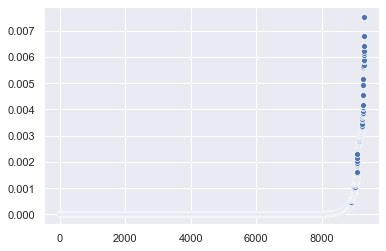

In [45]:
def get_sorted_list_from_dict(dic):
    dic_f = sorted(dic.items(), key=operator.itemgetter(1))
    ckeys=range(len(dic_f))
    keys=[]
    values=[]
    for i in dic_f:
        keys.append(i[0])
        values.append(i[1])
    return ckeys, keys, values


t1,t2 = nx.hits(g, max_iter=100, tol=1e-08, nstart=None, normalized=True)
bc_ck,bc_k,bc_v=get_sorted_list_from_dict(t1)
sns.scatterplot(bc_ck, bc_v);

print("média: {}".format(mean(bc_v)))
print("Atores mais importantes:")



***Seção de Teste de Hipótese***

In [65]:
data2000.columns

Index(['url', 'WeekID', 'Week Position', 'Song_x', 'Performer_x', 'SongID',
       'Instance', 'Previous Week Position', 'Peak Position', 'Weeks on Chart',
       'sum100', 'inv', 'log', 'loginv', 'timestamp', 'Performer_y', 'Song_y',
       'spotify_genre', 'spotify_track_id', 'spotify_track_preview_url',
       'spotify_track_album', 'spotify_track_explicit',
       'spotify_track_duration_ms', 'spotify_track_popularity', 'danceability',
       'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature',
       'SongFiltred', 'eigen'],
      dtype='object')

In [46]:
def eigen(row):
    return t1[row["SongFiltred"]]

In [47]:
data2000['eigen']=data2000.apply (lambda row: eigen(row), axis=1)

In [89]:
data2000.columns

Index(['url', 'WeekID', 'Week Position', 'Song_x', 'Performer_x', 'SongID',
       'Instance', 'Previous Week Position', 'Peak Position', 'Weeks on Chart',
       'sum100', 'inv', 'log', 'loginv', 'timestamp', 'Performer_y', 'Song_y',
       'spotify_genre', 'spotify_track_id', 'spotify_track_preview_url',
       'spotify_track_album', 'spotify_track_explicit',
       'spotify_track_duration_ms', 'spotify_track_popularity', 'danceability',
       'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature',
       'SongFiltred', 'eigen'],
      dtype='object')

In [90]:
data2000.loc[:20,['SongID','danceability','spotify_track_explicit',
       'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness','spotify_track_popularity']]

,SongID,danceability,spotify_track_explicit,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,spotify_track_popularity
0,7 RingsAriana Grande,0.778,1.0,0.317,1.0,-10.732,0.0,0.3340,0.59200,0.000000,0.0881,91.0
1,SuckerJonas Brothers,0.842,0.0,0.734,1.0,-5.065,0.0,0.0588,0.04270,0.000000,0.1060,87.0
2,"Break Up With Your Girlfriend, I'm BoredAriana...",0.726,1.0,0.554,5.0,-5.290,0.0,0.0917,0.04210,0.000000,0.1060,85.0
3,SenoritaShawn Mendes & Camila Cabello,0.759,0.0,0.540,9.0,-6.039,0.0,0.0287,0.03700,0.000000,0.0945,94.0
4,Sicko ModeTravis Scott,0.834,1.0,0.730,8.0,-3.714,1.0,0.2220,0.00513,0.000000,0.1240,88.0
5,Please MeCardi B & Bruno Mars,0.747,1.0,0.570,1.0,-6.711,1.0,0.0810,0.06420,0.000000,0.0832,79.0
6,ApplauseLady Gaga,0.669,0.0,0.780,7.0,-4.287,0.0,0.0530,0.02650,0.000002,0.1430,71.0
7,Story Of My LifeOne Direction,0.600,0.0,0.663,3.0,-5.802,1.0,0.0477,0.22500,0.000000,0.1190,81.0
8,"Bang BangJessie J, Ariana Grande & Nicki Minaj",0.706,0.0,0.786,0.0,-3.417,0.0,0.0909,0.26000,0.000000,0.3800,79.0
9,Summer SixteenDrake,0.592,1.0,0.455,1.0,-7.698,1.0,0.3930,0.00322,0.000037,0.1540,60.0


In [104]:
model = sm.OLS(data2000['spotify_track_popularity'], data2000[['eigen','danceability',
       'energy', 'loudness', 'speechiness', 'acousticness']])
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    OLS Regression Results                                   
=============================================================================================
Dep. Variable:     spotify_track_popularity   R-squared (uncentered):                   0.943
Model:                                  OLS   Adj. R-squared (uncentered):              0.943
Method:                       Least Squares   F-statistic:                          1.983e+04
Date:                      Fri, 13 Nov 2020   Prob (F-statistic):                        0.00
Time:                              23:47:15   Log-Likelihood:                         -29746.
No. Observations:                      7251   AIC:                                  5.950e+04
Df Residuals:                          7245   BIC:                                  5.954e+04
Df Model:                                 6                                                  
Covariance Type:                  nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
loginv           1.6529      0.052     31.494      0.000       1.550       1.756
danceability    24.5019      1.085     22.589      0.000      22.376      26.628
energy          30.9686      0.736     42.094      0.000      29.526      32.411
loudness        -2.2569      0.078    -28.853      0.000      -2.410      -2.104
speechiness     11.1060      1.658      6.697      0.000       7.855      14.357
acousticness    13.9979      0.905     15.468      0.000      12.224      15.772
==============================================================================
Omnibus:                      204.685   Durbin-Watson:                   1.538
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              247.514
Skew:                          -0.357   Prob(JB):                     1.79e-54
Kurtosis:                       3.555   Cond. No.                         70.8
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [75]:
dataeigen = data2000.sort_values(by=['eigen'])

In [76]:
def plotcalor(nome):
    xv=7
    yv=6
    dx=max(dataeigen["eigen"])/xv
    dy=max(dataeigen[nome])/yv
    
    heatmap=np.array([[0.0]*xv]*xv)
    for i in range(xv):
        cat=0
        
        lista=[0]*xv
        for j in dataeigen.index:
            if (dataeigen["eigen"][j]<(dx*i+dx) and dataeigen["eigen"][j]>(dx*i)):
                cat+=1 
        
        for j in dataeigen.index:
            for k in range(xv):
                if (dataeigen["eigen"][j]<=(dx*i+dx) and dataeigen["eigen"][j]>(dx*i)):
                    if (dataeigen[nome][j]<=(dy*k+dy) and dataeigen[nome][j]>(dy*k)):
                        lista[k]+=1/cat
        for j in range(len(lista)):
            
            heatmap[xv-j-1][i]=lista[j]
            
    print(heatmap)
    fig, ax = plt.subplots()
    im = ax.imshow(heatmap)
    fig.tight_layout()
    plt.show()

[[0.         0.         0.         0.         0.         0.
  0.        ]
 [0.00338219 0.         0.         0.         0.         0.
  0.        ]
 [0.00507328 0.         0.00813008 0.         0.         0.
  0.        ]
 [0.01578354 0.         0.01626016 0.         0.         0.
  0.        ]
 [0.04453213 0.01190476 0.04065041 0.05357143 0.         0.
  0.        ]
 [0.15163472 0.20238095 0.15447154 0.17857143 0.         0.2
  0.75      ]
 [0.77903044 0.78571429 0.7804878  0.76785714 1.         0.8
  0.5       ]]


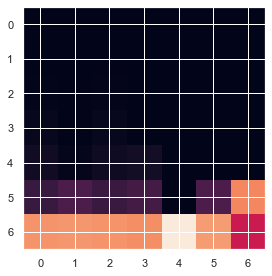

In [77]:
plotcalor("loginv")



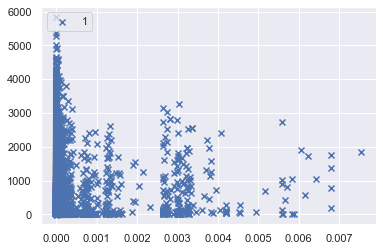

In [78]:
plt.scatter(dataeigen["eigen"],dataeigen["sum100"], c='b', marker='x', label='1')
plt.legend(loc='upper left')
plt.show()

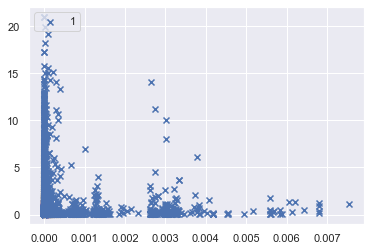

In [79]:
plt.scatter(dataeigen["eigen"],dataeigen["inv"], c='b', marker='x', label='1')
plt.legend(loc='upper left')
plt.show()

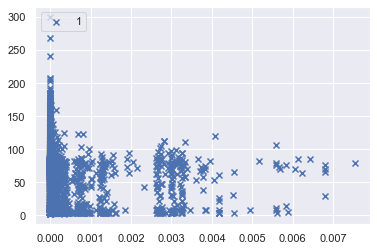

In [80]:
plt.scatter(dataeigen["eigen"],dataeigen["log"], c='b', marker='x', label='1')
plt.legend(loc='upper left')
plt.show()

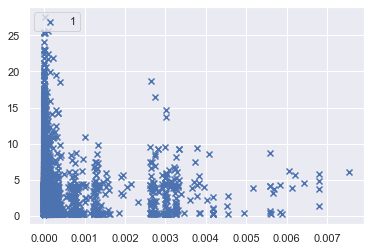

In [81]:
plt.scatter(dataeigen["eigen"],dataeigen["loginv"], c='b', marker='x', label='1')
plt.legend(loc='upper left')
plt.show()

In [82]:
def conv_string_to_list(string):
    new=string.replace("'","")
    new=new.replace('"',"")
    new=new.strip('][').split(', ')
    return new

['dance pop', 'pop', 'post-teen pop']


In [84]:
lista_generos=[]


for i in data2000.index:
    
    gen= conv_string_to_list(data2000["spotify_genre"][i])
    
    for j in range(len(gen)):
        if gen[j] not in lista_generos:
            lista_generos.append(gen[j])
            
lista_musicas_generos=[]
print("vai")
for i in data2000.index:
    insertfeat(lista_musicas_generos,gen,data2000["SongFiltred"][i])
    

    


vai
['dance pop', 'pop', 'post-teen pop', 'boy band', 'pop rock', 'canadian pop', 'viral pop', 'rap', 'pop rap', 'talent show', 'australian pop', 'uk pop', 'canadian hip hop', 'hip hop', 'toronto rap', 'conscious hip hop', 'nc hip hop', 'atl hip hop', 'southern hip hop', 'detroit hip hop', 'g funk', 'electropop', 'tropical house', 'canadian contemporary r&b', 'dfw rap', 'melodic rap', 'permanent wave', 'glee club', 'hollywood', 'british soul', 'neo mellow', 'k-pop', 'k-pop boy group', 'new orleans rap', 'trap', 'hip pop', 'queens hip hop', 'contemporary country', 'country', 'country pop', 'country road', 'modern country rock', 'r&b', 'chicago rap', 'idol', 'neo soul', 'urban contemporary', 'barbadian pop', 'piano rock', 'edm', 'new jack swing', 'quiet storm', 'candy pop', 'alternative metal', 'post-grunge', 'dirty south rap', 'gangster rap', 'miami hip hop', 'colombian pop', 'latin', 'latin pop', 'mexican pop', 'art pop', 'metropopolis', 'nz pop', 'east coast hip hop', 'funk metal', 'n

In [85]:
with open("genre.gml","w") as content:
    content.writelines("graph [\n  directed 1\n")
    for i in range(len(lista_generos)):
        line="  node [\n    id \"{}\"\n  ]\n".format(lista_generos[i])
        content.writelines(line)
    for i in range(len(lista_musicas)):
        line="  node [\n    id \"{}\"\n  ]\n".format(lista_musicas[i])
        content.writelines(line)
    for i in range(len(lista_musicas_generos)):
        line="  edge [\n    source \"{0}\"\n    target \"{1}\"\n    weight {2}\n  ]\n".format(lista_musicas_generos[i][0],lista_musicas_generos[i][1],1)
        content.writelines(line)
        line="  edge [\n    source \"{0}\"\n    target \"{1}\"\n    weight {2}\n  ]\n".format(lista_musicas_generos[i][1],lista_musicas_generos[i][0],1)
        content.writelines(line)
    content.writelines("]")

In [86]:
h = fm.load('genre.gml')

h.label_nodes()
h.set_all_nodes(size=1, labpos='hover')
h.set_all_edges(color=(0, 0, 0, 0.5))

h.interact()

In [87]:
u1 = nx.betweenness_centrality(h)
bc_ck,bc_k,bc_v=get_sorted_list_from_dict(u1)
sns.scatterplot(bc_ck, bc_v);

print("média: {}".format(mean(bc_v)))
print("Atores mais importantes:")

KeyboardInterrupt: 

In [ ]:
print(u1)